# 🧙‍♂️ Sample Generation with Pretrained Model + LLLA

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Jac-Zac/PML_DL_Final_Project/blob/master/notebooks/notebook_llla_diff.ipynb)

### Initial setup ⚙️

In [1]:
# !pip install laplace-torch

In [2]:
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

In [3]:
if IN_COLAB:
    import os

    # !pip install laplace-torch -q
    repo_dir = "PML_DL_Final_Project"

    if not os.path.exists(repo_dir):
        !git clone https://github.com/Jac-Zac/PML_DL_Final_Project.git
    else:
        print(f"Repository '{repo_dir}' already exists. Skipping clone.")


    if os.path.isdir(repo_dir):
        %cd $repo_dir
        !pip install dotenv -q
    else:
        print(f"Directory '{repo_dir}' not found. Please clone the repository first.")

else:
    %cd ..

/Users/jaczac/Github/PML_DL_Final_Project


### 📦 Imports

In [4]:
import torch

from src.models.diffusion import Diffusion

from src.utils.data import get_dataloaders
from src.utils.plots import plot_image_grid, plot_image_uncertainty_grid
from src.utils.environment import get_device, set_seed, load_pretrained_model
import os

# Since on a notebook we can have nicer bars
# from tqdm.notebook import tqdm
from tqdm import tqdm

### 🧪 Setup: Seed and Device

In [5]:
seed = 1337
set_seed(seed)
device = get_device()
os.makedirs("checkpoints", exist_ok=True)

## 💡 Image Generation

#### Define Class for QUDiffusion

In [13]:
from typing import List, Optional, Tuple
import torch
from torch import Tensor, nn

class UQDiffusion(Diffusion):
    """
    Diffusion model with uncertainty estimation capabilities.
    Extends the base Diffusion class to support Laplace approximation models.
    """

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def perform_training_step(
        self,
        model: nn.Module,
        x_0: Tensor,
        y: Optional[Tensor] = None,
        t: Optional[Tensor] = None,
    ) -> Tensor:
        """Override to use accurate_forward during training if available."""
        x_0 = x_0.to(self.device)
        if t is None:
            t = self._sample_timesteps(x_0.size(0))
        x_t, noise = self._sample_q(x_0, t)

        noise_pred = model(x_t, t, y=y)

        return self.loss_simple(noise, noise_pred)

    @torch.no_grad()
    def monte_carlo_covariance_estim(
        self,
        model: nn.Module,
        t: Tensor,
        x_mean: Tensor,
        x_var: Tensor,
        S: int = 10,
        y: Optional[Tensor] = None,
    ) -> Tensor:
        """
        Perform Monte Carlo sampling to estimate covariance matrix.
        Args:
            mean_x0: Mean of x_0 estimated by diffusion.
            var_x0: Variance of x_0 estimated by propagation.
            S: Number of Monte Carlo samples.

        Returns:
            mc_mean: Empirical mean of samples.
            mc_var: Empirical pixel-wise variance of samples.
        """
        std_x = torch.sqrt(torch.clamp(x_var, min=1e-8))
        x_samples = [x_mean + std_x * torch.randn_like(x_mean) for _ in range(S)]
        eps = [model.accurate_forward(x_i, t, y=y) for x_i in x_samples]
        
        x_samples = torch.stack(x_samples, dim=0)  # [S, B, C, H, W]
        eps = torch.stack(eps, dim=0)  # [S, B, C, H, W]

        """
        first_term = torch.mean(x_samples * eps, dim=0)  # [B, C, H, W]
        second_term = x_mean * torch.mean(eps, dim=0)  # [B, C, H, W]

        return first_term - second_term
        """
        
        # Reshape to [S, B*C*H*W]
        S, B, C, H, W = x_samples.shape
        x_flat = x_samples.view(S, -1)
        eps_flat = eps.view(S, -1)
    
        # Subtract sample means
        x_centered = x_samples - x_samples.mean(dim=0)
        eps_centered = eps - eps.mean(dim=0)
    
        # Compute covariance (sample covariance)
        cov_diag = (x_centered * eps_centered).mean(dim=0)  # element-wise product
    
        # Reshape back to [B, C, H, W]
        cov_diag = cov_diag.view(B, C, H, W)
    
        return cov_diag


    @torch.no_grad()
    def sample_with_uncertainty(
        self,
        model: nn.Module,
        t_sample_times: Optional[List[int]] = None,
        channels: int = 1,
        log_intermediate: bool = True,
        y: Optional[Tensor] = None,
        cov_num_sample: int = 10,
    ) -> Tuple[List[Tensor], Tensor]:
        """
        Iteratively sample from the model, tracking predictive uncertainty and optionally Cov(x, ε).
        """
        model.eval()
        batch_size = 1 if y is None else y.size(0)

        x_t = torch.randn(
            batch_size, channels, self.img_size, self.img_size, device=self.device
        )

        x_t_mean = x_t.clone()
        x_t_var = torch.zeros_like(x_t)
        cov_t = torch.zeros_like(x_t)

        intermediates, uncertainties = [], []

        for i in tqdm(reversed(range(self.noise_steps)), desc="Steps", leave=False):
            t = torch.full((batch_size,), i, device=self.device, dtype=torch.long)

            # Predict noise and its variance
            eps_mean, eps_var = model(x_t, t, y=y)  # mean and variance of noise
            eps_t = eps_mean + torch.sqrt(eps_var) * torch.randn_like(eps_mean)

            # Compute xt-1
            beta_t = self.beta[t].view(-1, 1, 1, 1)
            alpha_t = self.alpha[t].view(-1, 1, 1, 1)
            alpha_bar_t = self.alpha_bar[t].view(-1, 1, 1, 1)

            # Mean and x_t-1
            coef1 = 1.0 / alpha_t.sqrt()
            coef2 = (1.0 - alpha_t) / (1.0 - alpha_bar_t).sqrt()
            x_prev_mean = coef1 * (x_t_mean - coef2 * eps_mean)
            x_prev = (
                coef1 * (x_t - coef2 * eps_t) + torch.randn_like(x_t) * beta_t.sqrt()
            )

            # Variance
            coef3 = 2 * (1 - alpha_t) / alpha_t * (1 - alpha_bar_t).sqrt()
            coef4 = (1 - alpha_t)**2 / alpha_t * (1 - alpha_bar_t)
            x_prev_var = (
                # (1 / alpha_t * x_t_var) - (coef3 * cov_t) + (coef4 * eps_var) + beta_t
                (1 / alpha_t * x_t_var) + (coef4 * eps_var) + beta_t
            )

            if i > 0:
                # Covariance estimation with Monte Carlo
                covariance = self.monte_carlo_covariance_estim(
                    model=model,
                    t=t - 1,
                    x_mean=x_prev_mean,
                    x_var=x_prev_var,
                    S=cov_num_sample,
                    y=y,
                )

            log = False
            if (i % 100 == 0 or i == self.noise_steps - 1) and log == True:
                print(f"\nStep {i}")
                print(f"  eps_var mean: {eps_var.mean().item():.4e}, std: {eps_var.std().item():.4e}")
                if i > 0:
                    print(f"  Covariance mean: {covariance.mean().item():.4e}, std: {covariance.std().item():.4e}")
                print(f"  x_t_var mean: {x_t_var.mean().item():.4e}, std: {x_t_var.std().item():.4e}")
                print(f"  x_prev_var mean: {x_prev_var.mean().item():.4e}, std: {x_prev_var.std().item():.4e}")


            # Log intermediate images
            if log_intermediate and t_sample_times and i in t_sample_times:
                intermediates.append(self.transform_sampled_image(x_t.clone()))
                uncertainties.append(x_t_var.clone().cpu())  # per-pixel variance

            x_t = x_prev
            x_t_mean = x_prev_mean
            x_t_var = x_prev_var
            cov_t = covariance

        uncertainties = torch.stack(uncertainties)  # [num_steps, B, C, H, W]

        model.train()
        return intermediates, uncertainties

#### 🛠️ Configuration Parameters

In [7]:
n_samples = 5
save_dir = "samples"
model_name = "unet"
method = "diffusion"  # or "flow"
ckpt_path = "checkpoints/best_model.pth"  # or use your last checkpoint

### 💪 Fit Laplace approximation

In [8]:
from src.models.llla_model import LaplaceApproxModel
from src.utils.data import get_llla_dataloader
from types import SimpleNamespace

num_classes = 10
model_kwargs = {
    "num_classes": num_classes,
    "time_emb_dim": 128,
    # NOTE: Change time embedding to learned for flow which is more sensible
    "time_embedding_type": "mlp" if method == "flow" else "sinusoidal",
}


# Load pretrained MAP model using best checkpoint
diff_model = load_pretrained_model(
    model_name="unet",
    ckpt_path="jac-zac/diffusion-project/best-model:v80",
    device=device,
    model_kwargs=model_kwargs,
    use_wandb=True,
)

# 2️⃣ Prepare data loaders for the Laplace fit
train_loader, _ = get_llla_dataloader(batch_size=128, mode = "diffusion")

mnist_config = SimpleNamespace()
mnist_config.data = SimpleNamespace()
mnist_config.data.image_size = 28  # MNIST image size
#mnist_config.mode = "flow"

# Wrap diffusion model with your Custom Model for Laplace last layer approx
# NOTE: Automatically call fit
laplace_model = LaplaceApproxModel(
    diff_model, train_loader, args=None, config=mnist_config
)

print("Laplace fitting completed on last layer of the diffusion model.")

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: WARNING Unable to write /Users/jaczac/.config/netrc/netrc
wandb: Currently logged in as: jacopozac (jac-zac) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb:   1 of 1 files downloaded.  
                                                                                                                                                                                    

Laplace fitting completed on last layer of the diffusion model.



<!-- #region id="1d2b6a2d" -->
### 💨 Initialize Diffusion Process

In [15]:
num_intermediate = 15
total_steps = 1000

# Initialize uncertainty-aware diffusion (same interface as base class)
diffusion = UQDiffusion(img_size=28, device=device)

all_samples_grouped, uncertainties = plot_image_uncertainty_grid(
        laplace_model,
        diffusion,
        num_intermediate=num_intermediate,
        n=1,
        total_steps=total_steps,
        save_dir=save_dir,
        device=device,
        num_classes=num_classes,
        cov_num_sample=1,
        uq_cmp = "viridis",
    )

CPU times: user 13.4 s, sys: 3.99 s, total: 17.3 s
Wall time: 13.2 s


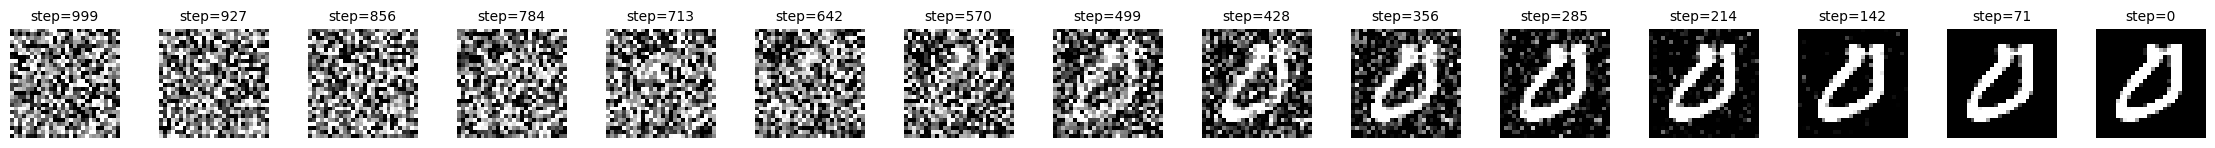

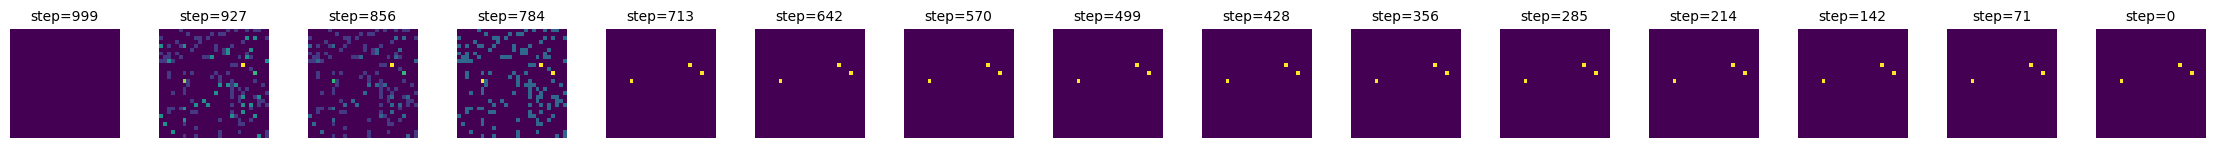

In [16]:
from PIL import Image

# Display samples grid
out_path_img = os.path.join(save_dir, "all_samples_grid.png")
display(Image.open(out_path_img))

# Display uncertainties grid
out_path_unc = os.path.join(save_dir, "all_uncertainties_grid.png")
display(Image.open(out_path_unc))

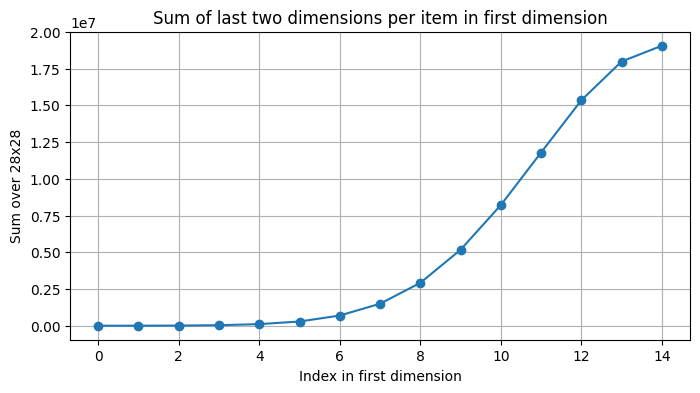

In [17]:
import torch
import matplotlib.pyplot as plt
# Sum over the last two dimensions (28x28)
sums = uncertainties.sum(dim=[-1, -2])  # shape: [10, 1, 1]

# Flatten to shape
sums_flat = sums.view(num_intermediate)

# Plot
plt.figure(figsize=(8, 4))
plt.plot(range(num_intermediate), sums_flat.tolist(), marker='o', linestyle='-')
plt.title("Sum of last two dimensions per item in first dimension")
plt.xlabel("Index in first dimension")
plt.ylabel("Sum over 28x28")
plt.grid(True)
plt.show()